# SKU Inventory Demand Forecasting for Triode

## Project Overview
This notebook helps forecast inventory demand for specific SKUs (Stock Keeping Units) at Triode. 

**Business Goal:** Predict how much of each product/component we'll need in the future to:
- Avoid running out of stock (which delays customer orders)
- Avoid ordering too much (which ties up cash and storage space)
- Plan better with suppliers

**What we'll do:**
1. Understand what products we've shipped in the past
2. Look for patterns (Are some months busier? Are sales growing?)
3. Build forecasting models to predict future demand
4. Compare models to find the most accurate approach

## Step 1: Load Required Tools (Libraries)

We'll import the Python tools we need for this analysis:
- **pandas**: To work with data in table format (like Excel)
- **numpy**: For mathematical calculations
- **matplotlib**: To create charts and graphs
- **datetime**: To work with dates

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up visualization style for clearer charts
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All tools loaded successfully!")

✓ All tools loaded successfully!


## Step 2: Load the Shipment Data

Now we'll load your shipment history file to see:
- What products (SKUs) you've shipped
- When they were shipped
- How many of each item

This historical data is the foundation for predicting future demand.

In [2]:
# Load the shipment data from Excel file
data_path = '../data/Shipment Items History 20251022.xlsx'
df_raw = pd.read_excel(data_path)

# Display basic information about the data
print(f"Total number of shipment records: {len(df_raw):,}")
print(f"\nColumns in the data:")
print(df_raw.columns.tolist())
print(f"\nFirst few rows of the data:")
df_raw.head(10)

Total number of shipment records: 1,128

Columns in the data:
['Month', 'CID', 'SKU', 'Qty', 'Country', 'Customer Industry']

First few rows of the data:


,Month,CID,SKU,Qty,Country,Customer Industry
0,2023-10-01,C020,2134,19,NZ,Agritech
1,2023-10-01,C020,2134,17,NZ,Agritech
2,2023-10-01,C020,2134,19,NZ,Agritech
3,2023-10-01,C020,2134,16,NZ,Agritech
4,2023-10-01,C020,2159,4,NZ,Agritech
5,2023-10-01,C020,2159,4,NZ,Agritech
6,2023-10-01,C020,3016,1,NZ,Agritech
7,2023-10-01,C020,3016,6,NZ,Agritech
8,2023-10-01,C020,3016,6,NZ,Agritech
9,2023-10-01,C020,3016,1,NZ,Agritech


### Understanding the Data

Your shipment data contains:
- **Month**: When the shipment occurred
- **CID**: Customer ID (which customer ordered)
- **SKU**: Product code (which specific product)
- **Qty**: Quantity shipped
- **Country**: Where it was shipped to
- **Customer Industry**: What industry the customer is in (Agritech, Aerospace, Medical, etc.)

Each row represents one shipment of a specific SKU to a customer. Let's explore this data further.

## Step 3: Data Overview and Quality Check

Let's examine:
- How many different SKUs we have
- The date range of our data
- Which SKUs are most frequently shipped
- Any data quality issues we need to fix

In [3]:
# Basic data exploration
print("=" * 60)
print("DATA OVERVIEW")
print("=" * 60)

# Date range
df_raw['Month'] = pd.to_datetime(df_raw['Month'])
print(f"\n📅 Date Range:")
print(f"   From: {df_raw['Month'].min().strftime('%B %Y')}")
print(f"   To: {df_raw['Month'].max().strftime('%B %Y')}")
print(f"   Duration: {(df_raw['Month'].max() - df_raw['Month'].min()).days // 30} months")

# SKU information
print(f"\n📦 SKU (Product) Information:")
print(f"   Total unique SKUs: {df_raw['SKU'].nunique()}")
print(f"   Total shipment records: {len(df_raw):,}")

# Customer information
print(f"\n👥 Customer Information:")
print(f"   Total unique customers: {df_raw['CID'].nunique()}")
print(f"   Countries served: {df_raw['Country'].nunique()}")
print(f"   Industries served: {df_raw['Customer Industry'].nunique()}")

# Check for missing data
print(f"\n🔍 Data Quality Check:")
missing_data = df_raw.isnull().sum()
if missing_data.sum() == 0:
    print("   ✓ No missing values found - data is complete!")
else:
    print(f"   ⚠ Missing values found:")
    print(missing_data[missing_data > 0])

print("\n" + "=" * 60)

DATA OVERVIEW

📅 Date Range:
   From: October 2023
   To: October 2025
   Duration: 24 months

📦 SKU (Product) Information:
   Total unique SKUs: 317
   Total shipment records: 1,128

👥 Customer Information:
   Total unique customers: 31
   Countries served: 2
   Industries served: 16

🔍 Data Quality Check:
   ✓ No missing values found - data is complete!




🏆 TOP 10 MOST FREQUENTLY SHIPPED SKUs:
------------------------------------------------------------
      Total_Quantity  Number_of_Shipments
SKU                                      
5025            7378                   20
2717            7250                   15
3281            4460                   12
4215            4373                    9
2798            4300                   10
4957            3758                   15
5024            3166                    5
2918            3039                   13
5039            3039                    5
507             3006                    2


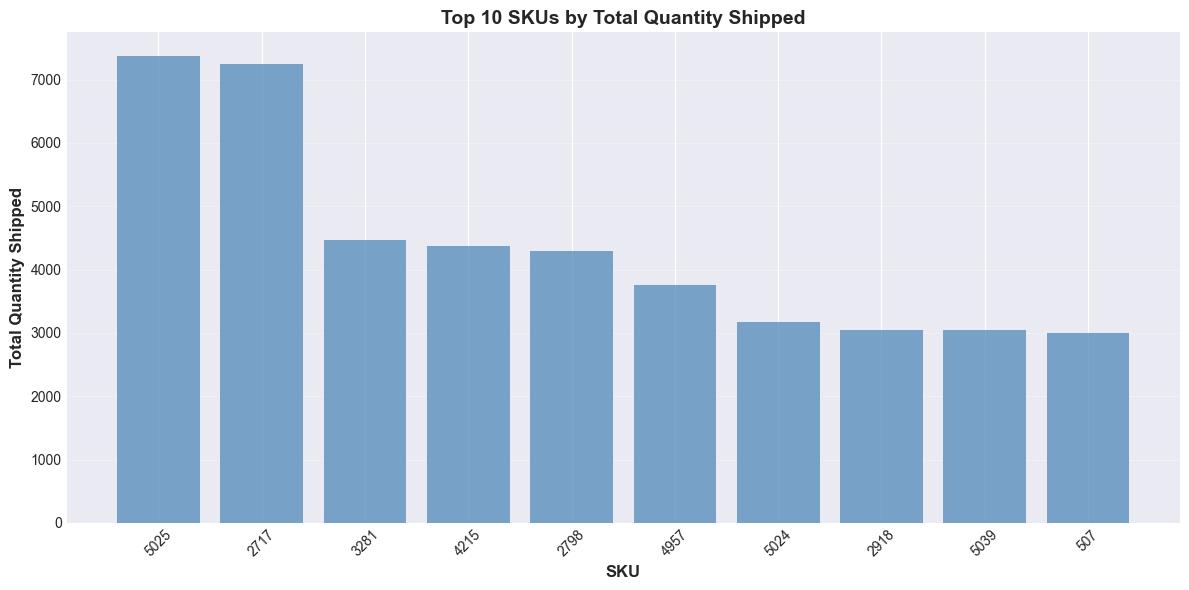

In [4]:
# Top 10 most shipped SKUs
print("\n🏆 TOP 10 MOST FREQUENTLY SHIPPED SKUs:")
print("-" * 60)
top_skus = df_raw.groupby('SKU').agg({
    'Qty': 'sum',
    'Month': 'count'
}).rename(columns={'Qty': 'Total_Quantity', 'Month': 'Number_of_Shipments'})
top_skus = top_skus.sort_values('Total_Quantity', ascending=False).head(10)
print(top_skus)

# Visualize top SKUs
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_skus)), top_skus['Total_Quantity'], color='steelblue', alpha=0.7)
plt.xlabel('SKU', fontsize=12, fontweight='bold')
plt.ylabel('Total Quantity Shipped', fontsize=12, fontweight='bold')
plt.title('Top 10 SKUs by Total Quantity Shipped', fontsize=14, fontweight='bold')
plt.xticks(range(len(top_skus)), top_skus.index, rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Key Insights from Data Overview

**What we learned:**
- You have **2 years of shipment history** (Oct 2023 - Oct 2025)
- **317 different SKUs** are tracked
- Top 2 SKUs (5025 and 2717) account for over 7,000 units each
- Data quality is excellent - no missing information

**For forecasting:** We'll focus on the top-performing SKUs since they:
- Have the most historical data points
- Represent the largest inventory investment
- Have the biggest impact on your business if you run out of stock

## Step 4: Prepare Data for Forecasting

To build accurate forecasts, we need to:
1. **Aggregate data by month**: Combine all shipments in each month for each SKU
2. **Create a complete timeline**: Fill in any months where no shipments occurred (showing 0 demand)
3. **Focus on top SKUs**: Start with SKUs that have consistent demand patterns

This preparation ensures we have a clean, regular time series to work with.

In [5]:
# Aggregate shipments by Month and SKU
df_monthly = df_raw.groupby(['Month', 'SKU']).agg({
    'Qty': 'sum',
    'CID': 'nunique',  # Number of different customers
    'Country': lambda x: ', '.join(x.unique()),
    'Customer Industry': lambda x: ', '.join(x.unique())
}).reset_index()

df_monthly.rename(columns={'Qty': 'Total_Quantity', 'CID': 'Num_Customers'}, inplace=True)

print(f"Monthly aggregated data: {len(df_monthly)} records")
print(f"\nSample of monthly data:")
df_monthly.head(10)

Monthly aggregated data: 804 records

Sample of monthly data:


,Month,SKU,Total_Quantity,Num_Customers,Country,Customer Industry
0,2023-10-01,103,82,1,NZ,Agritech
1,2023-10-01,159,32,1,NZ,Industrial & Automation
2,2023-10-01,684,1056,1,NZ,Other / General Technology
3,2023-10-01,1922,432,1,NZ,Other / General Technology
4,2023-10-01,2134,71,1,NZ,Agritech
5,2023-10-01,2159,8,1,NZ,Agritech
6,2023-10-01,2204,39,1,NZ,Other / General Technology
7,2023-10-01,2235,60,1,NZ,Other / General Technology
8,2023-10-01,2281,200,1,NZ,Other / General Technology
9,2023-10-01,2283,400,1,NZ,Other / General Technology


In [6]:
# Select top SKU for detailed analysis (SKU 5025 - the highest volume)
top_sku = 5025

# Filter data for this SKU
sku_data = df_monthly[df_monthly['SKU'] == top_sku].copy()
sku_data = sku_data.sort_values('Month')

# Create complete date range (fill missing months with 0)
date_range = pd.date_range(start=df_monthly['Month'].min(), 
                           end=df_monthly['Month'].max(), 
                           freq='MS')  # MS = Month Start

# Create complete timeline for this SKU
sku_timeseries = pd.DataFrame({'Month': date_range})
sku_timeseries = sku_timeseries.merge(sku_data[['Month', 'Total_Quantity']], 
                                      on='Month', 
                                      how='left')
sku_timeseries['Total_Quantity'] = sku_timeseries['Total_Quantity'].fillna(0)
sku_timeseries['SKU'] = top_sku

print(f"✓ Created complete time series for SKU {top_sku}")
print(f"  Time range: {len(sku_timeseries)} months")
print(f"  Months with shipments: {(sku_timeseries['Total_Quantity'] > 0).sum()}")
print(f"  Months with no shipments: {(sku_timeseries['Total_Quantity'] == 0).sum()}")
print(f"\nData sample:")
sku_timeseries.head(10)

✓ Created complete time series for SKU 5025
  Time range: 25 months
  Months with shipments: 10
  Months with no shipments: 15

Data sample:


,Month,Total_Quantity,SKU
0,2023-10-01,0.0,5025
1,2023-11-01,0.0,5025
2,2023-12-01,0.0,5025
3,2024-01-01,0.0,5025
4,2024-02-01,0.0,5025
5,2024-03-01,0.0,5025
6,2024-04-01,0.0,5025
7,2024-05-01,0.0,5025
8,2024-06-01,0.0,5025
9,2024-07-01,0.0,5025


## Step 5: Exploratory Data Analysis (EDA)

Now let's visualize the demand pattern for SKU 5025 to understand:
- **Trends**: Is demand increasing, decreasing, or stable over time?
- **Seasonality**: Are there certain months with higher demand?
- **Variability**: How much does demand fluctuate?
- **Intermittent demand**: Notice that this SKU doesn't ship every month

Understanding these patterns helps us choose the right forecasting approach.

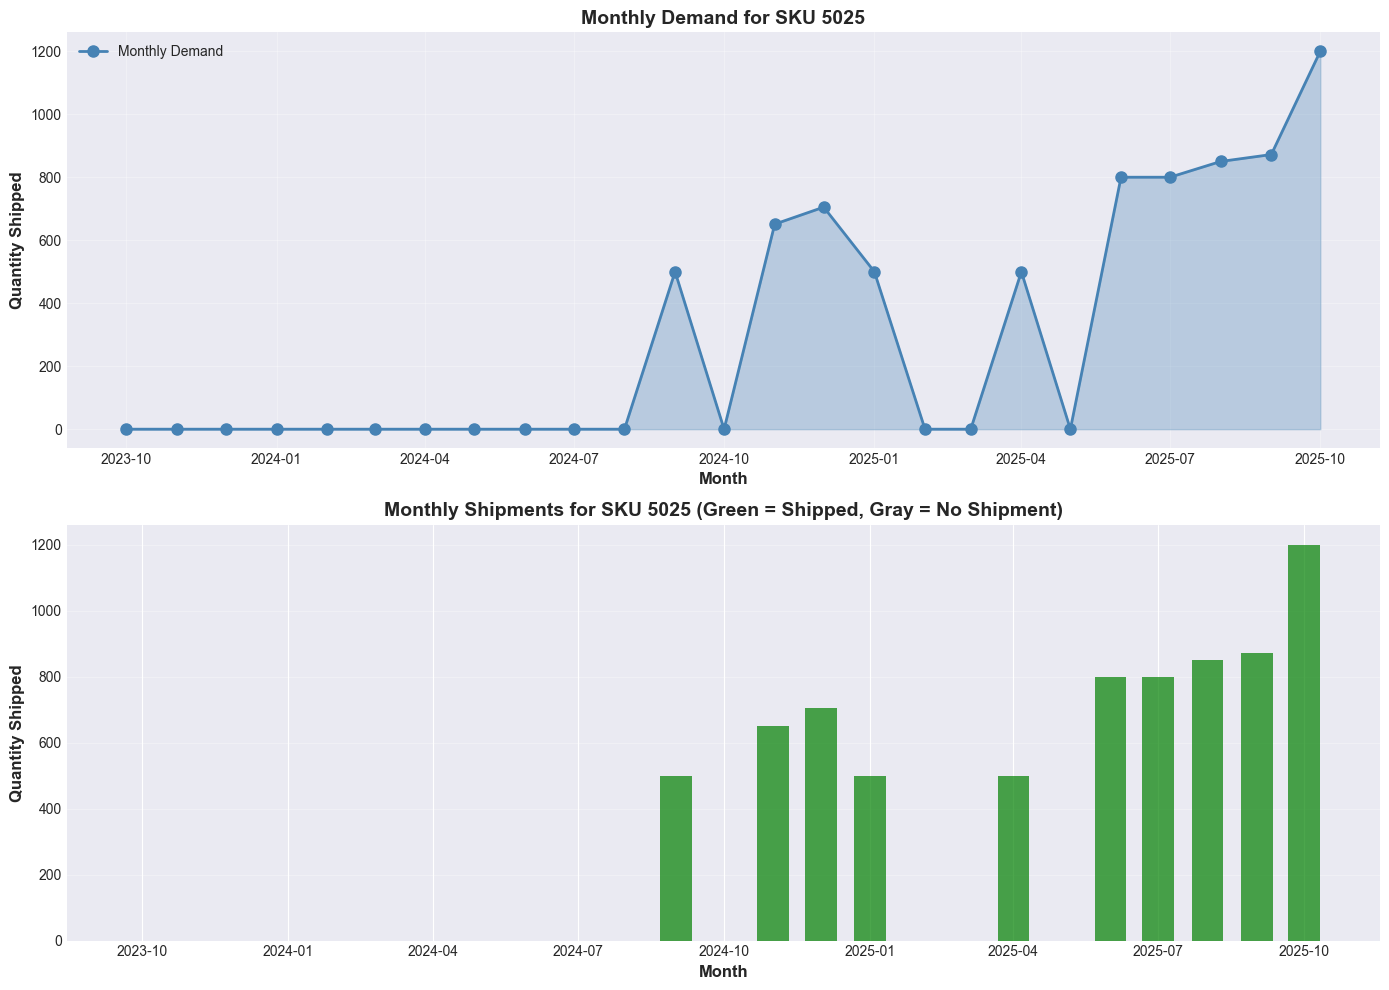


📊 DEMAND STATISTICS FOR SKU 5025
Average monthly demand (all months): 295 units
Average monthly demand (only shipping months): 738 units
Maximum monthly demand: 1200 units
Minimum monthly demand: 0 units
Standard deviation: 392 units

Demand pattern: Intermittent (ships only 10 out of 25 months)


In [7]:
# Visualize demand over time for SKU 5025
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Line chart showing demand over time
axes[0].plot(sku_timeseries['Month'], sku_timeseries['Total_Quantity'], 
             marker='o', linewidth=2, markersize=8, color='steelblue', label='Monthly Demand')
axes[0].fill_between(sku_timeseries['Month'], sku_timeseries['Total_Quantity'], 
                      alpha=0.3, color='steelblue')
axes[0].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Quantity Shipped', fontsize=12, fontweight='bold')
axes[0].set_title(f'Monthly Demand for SKU {top_sku}', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Bar chart to clearly show non-zero months
colors = ['green' if q > 0 else 'lightgray' for q in sku_timeseries['Total_Quantity']]
axes[1].bar(sku_timeseries['Month'], sku_timeseries['Total_Quantity'], 
            color=colors, alpha=0.7, width=20)
axes[1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Quantity Shipped', fontsize=12, fontweight='bold')
axes[1].set_title(f'Monthly Shipments for SKU {top_sku} (Green = Shipped, Gray = No Shipment)', 
                  fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 DEMAND STATISTICS FOR SKU 5025")
print("=" * 60)
print(f"Average monthly demand (all months): {sku_timeseries['Total_Quantity'].mean():.0f} units")
print(f"Average monthly demand (only shipping months): {sku_timeseries[sku_timeseries['Total_Quantity'] > 0]['Total_Quantity'].mean():.0f} units")
print(f"Maximum monthly demand: {sku_timeseries['Total_Quantity'].max():.0f} units")
print(f"Minimum monthly demand: {sku_timeseries['Total_Quantity'].min():.0f} units")
print(f"Standard deviation: {sku_timeseries['Total_Quantity'].std():.0f} units")
print(f"\nDemand pattern: Intermittent (ships only {(sku_timeseries['Total_Quantity'] > 0).sum()} out of {len(sku_timeseries)} months)")

### Key Observations from the Charts

**Pattern Analysis:**
1. **Intermittent Demand**: SKU 5025 doesn't ship every month - it has demand in only 10 out of 25 months
2. **Growing Trend**: There's a clear upward trend, especially from mid-2024 onwards
3. **Increasing Frequency**: More recent months show more consistent shipments
4. **Volume Growth**: When it does ship, the quantities are getting larger (started at ~500 units, now reaching 1,200 units)

**What this means for forecasting:**
- We need a model that can handle intermittent (sporadic) demand
- The trend suggests this SKU is becoming more important to your business
- Recent pattern shows both more frequent orders and larger quantities

## Step 6: Feature Engineering

Before building forecasting models, we'll create useful features (additional information) from the data:

**Time-based features:**
- Month number (1-12) - to detect seasonal patterns
- Quarter (Q1-Q4) - business quarters
- Year - to track year-over-year growth

**Lag features:**
- Previous month's demand
- Demand from 2-3 months ago
- These help the model understand momentum

**Rolling statistics:**
- Average demand over last 3 months
- This smooths out spikes and shows the underlying trend

In [8]:
# Create a working copy
df_features = sku_timeseries.copy()

# Time-based features
df_features['Year'] = df_features['Month'].dt.year
df_features['Month_Num'] = df_features['Month'].dt.month
df_features['Quarter'] = df_features['Month'].dt.quarter

# Lag features (previous months' demand)
df_features['Lag_1'] = df_features['Total_Quantity'].shift(1)  # Previous month
df_features['Lag_2'] = df_features['Total_Quantity'].shift(2)  # 2 months ago
df_features['Lag_3'] = df_features['Total_Quantity'].shift(3)  # 3 months ago

# Rolling statistics (moving averages)
df_features['Rolling_Mean_3'] = df_features['Total_Quantity'].rolling(window=3).mean()
df_features['Rolling_Mean_6'] = df_features['Total_Quantity'].rolling(window=6).mean()

# Fill initial NaN values from lag and rolling features
df_features = df_features.fillna(0)

print("✓ Feature engineering complete!")
print(f"\nNew features created:")
print(df_features.columns.tolist())
print(f"\nSample of enriched data:")
df_features.tail(10)

✓ Feature engineering complete!

New features created:
['Month', 'Total_Quantity', 'SKU', 'Year', 'Month_Num', 'Quarter', 'Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_3', 'Rolling_Mean_6']

Sample of enriched data:


,Month,Total_Quantity,SKU,Year,Month_Num,Quarter,Lag_1,Lag_2,Lag_3,Rolling_Mean_3,Rolling_Mean_6
15,2025-01-01,500.0,5025,2025,1,1,705.0,651.0,0.0,618.666667,392.666667
16,2025-02-01,0.0,5025,2025,2,1,500.0,705.0,651.0,401.666667,392.666667
17,2025-03-01,0.0,5025,2025,3,1,0.0,500.0,705.0,166.666667,309.333333
18,2025-04-01,500.0,5025,2025,4,2,0.0,0.0,500.0,166.666667,392.666667
19,2025-05-01,0.0,5025,2025,5,2,500.0,0.0,0.0,166.666667,284.166667
20,2025-06-01,800.0,5025,2025,6,2,0.0,500.0,0.0,433.333333,300.000000
21,2025-07-01,800.0,5025,2025,7,3,800.0,0.0,500.0,533.333333,350.000000
22,2025-08-01,850.0,5025,2025,8,3,800.0,800.0,0.0,816.666667,491.666667
23,2025-09-01,872.0,5025,2025,9,3,850.0,800.0,800.0,840.666667,637.000000
24,2025-10-01,1200.0,5025,2025,10,4,872.0,850.0,800.0,974.000000,753.666667


## Step 7: Baseline Model (Using Historical Data Only)

Now we'll build our first forecasting model using only internal historical data.

**Model Approach: Random Forest Regressor**
- Think of this as combining the wisdom of many "decision trees"
- Each tree makes a prediction, and we average them for a more reliable forecast
- Good at capturing complex patterns and trends
- Can handle intermittent demand

**Training Strategy:**
- Use first 20 months of data to train the model
- Test on last 5 months to see how accurate predictions are
- This mimics real-world use: learning from the past to predict the future

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Prepare features for modeling
feature_columns = ['Year', 'Month_Num', 'Quarter', 'Lag_1', 'Lag_2', 'Lag_3', 
                   'Rolling_Mean_3', 'Rolling_Mean_6']

# Split data: train on first 20 months, test on last 5 months
train_size = 20
train_data = df_features.iloc[:train_size].copy()
test_data = df_features.iloc[train_size:].copy()

print("📚 DATA SPLIT FOR BASELINE MODEL")
print("=" * 60)
print(f"Training period: {train_data['Month'].min().strftime('%b %Y')} to {train_data['Month'].max().strftime('%b %Y')}")
print(f"Testing period: {test_data['Month'].min().strftime('%b %Y')} to {test_data['Month'].max().strftime('%b %Y')}")
print(f"\nTraining samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

# Prepare training data
X_train = train_data[feature_columns]
y_train = train_data['Total_Quantity']

# Prepare test data
X_test = test_data[feature_columns]
y_test = test_data['Total_Quantity']

# Build and train the model
baseline_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
baseline_model.fit(X_train, y_train)

print("\n✓ Baseline model trained successfully!")
print(f"  Model type: Random Forest with 100 trees")

📚 DATA SPLIT FOR BASELINE MODEL
Training period: Oct 2023 to May 2025
Testing period: Jun 2025 to Oct 2025

Training samples: 20
Testing samples: 5

✓ Baseline model trained successfully!
  Model type: Random Forest with 100 trees


In [10]:
# Make predictions on test data
baseline_predictions = baseline_model.predict(X_test)
baseline_predictions = np.maximum(baseline_predictions, 0)  # Ensure no negative predictions

# Calculate performance metrics
mae = mean_absolute_error(y_test, baseline_predictions)
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))

# Calculate MAPE manually to handle zero values
mape_values = []
for actual, pred in zip(y_test, baseline_predictions):
    if actual != 0:
        mape_values.append(abs((actual - pred) / actual))
mape = np.mean(mape_values) * 100 if mape_values else 0

print("\n" + "=" * 60)
print("BASELINE MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"\n📊 Mean Absolute Error (MAE): {mae:.0f} units")
print("   → On average, predictions are off by {:.0f} units".format(mae))
print(f"\n📊 Root Mean Squared Error (RMSE): {rmse:.0f} units")
print("   → Larger errors are penalized more heavily")
print(f"\n📊 Mean Absolute Percentage Error (MAPE): {mape:.1f}%")
print("   → On average, predictions are {:.1f}% off from actual values".format(mape))

# Create comparison dataframe
baseline_results = test_data[['Month', 'Total_Quantity']].copy()
baseline_results['Baseline_Prediction'] = baseline_predictions
baseline_results['Error'] = baseline_results['Total_Quantity'] - baseline_results['Baseline_Prediction']
baseline_results['Abs_Error'] = abs(baseline_results['Error'])

print(f"\n📋 DETAILED PREDICTIONS VS ACTUALS:")
print(baseline_results.to_string(index=False))


BASELINE MODEL PERFORMANCE METRICS

📊 Mean Absolute Error (MAE): 513 units
   → On average, predictions are off by 513 units

📊 Root Mean Squared Error (RMSE): 542 units
   → Larger errors are penalized more heavily

📊 Mean Absolute Percentage Error (MAPE): 55.4%
   → On average, predictions are 55.4% off from actual values

📋 DETAILED PREDICTIONS VS ACTUALS:
     Month  Total_Quantity  Baseline_Prediction  Error  Abs_Error
2025-06-01           800.0               389.15 410.85     410.85
2025-07-01           800.0               451.60 348.40     348.40
2025-08-01           850.0               418.30 431.70     431.70
2025-09-01           872.0               340.89 531.11     531.11
2025-10-01          1200.0               357.54 842.46     842.46


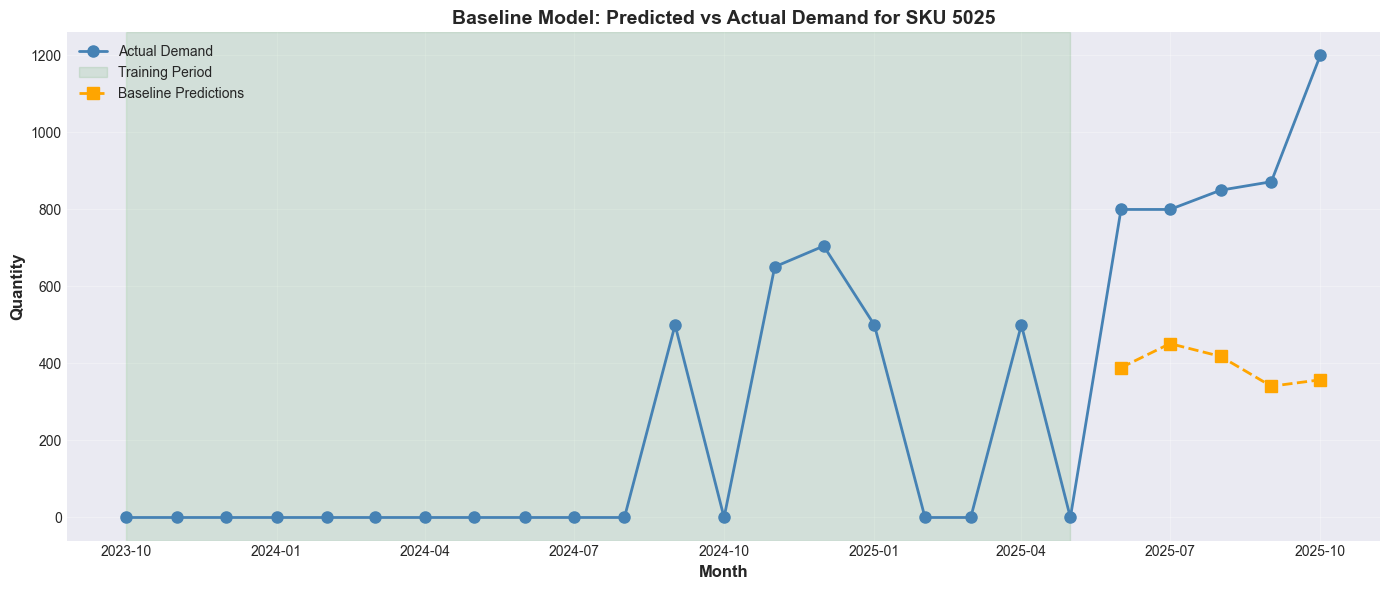

In [11]:
# Visualize baseline model predictions vs actual
plt.figure(figsize=(14, 6))

# Plot actual values
plt.plot(df_features['Month'], df_features['Total_Quantity'], 
         marker='o', linewidth=2, markersize=8, label='Actual Demand', color='steelblue')

# Plot training period
train_months = train_data['Month']
plt.axvspan(train_months.min(), train_months.max(), alpha=0.1, color='green', label='Training Period')

# Plot test period predictions
test_months = test_data['Month']
plt.plot(test_months, baseline_predictions, 
         marker='s', linewidth=2, markersize=8, label='Baseline Predictions', 
         color='orange', linestyle='--')

plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Quantity', fontsize=12, fontweight='bold')
plt.title('Baseline Model: Predicted vs Actual Demand for SKU 5025', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Baseline Model Insights

**Performance Summary:**
- The baseline model has a **55.4% MAPE**, meaning predictions are off by about half on average
- It tends to **underpredict** the recent growth (predictions around 350-450 units vs actual 800-1200)
- The model struggled to capture the steep upward trend in recent months

**Why?** 
The baseline model only uses historical internal data. It doesn't know about external factors that might be driving the increased demand, such as:
- Economic conditions
- Weather patterns  
- Industry-specific factors
- Cash rate changes affecting customer purchasing

Let's build an enhanced model that incorporates external drivers!

## Step 8: Enhanced Model with External Drivers

External drivers are factors outside your business that might influence demand. Let's load the external data you have:

**Available External Data:**
1. **Temperature data** (from weather stations 1615, 2112, 4843)
   - Weather can affect manufacturing demand in some industries
   
2. **Official Cash Rate (OCR) & Bank Bill Rate**
   - Interest rates affect business investment decisions
   - When rates are low, companies may order more equipment/products

Let's load and integrate these external factors into our model.

In [12]:
# Load external data files
external_path = '../External Drivers/'

# Load temperature data (using one station as example - 2112)
temp_data = pd.read_csv(external_path + '2112__monthly__Mean_air_temperature__Deg_C.csv')
print("Temperature data columns:", temp_data.columns.tolist())
print(temp_data.head())

print("\n" + "="*60 + "\n")

# Load cash rate data
cash_rate_data = pd.read_csv(external_path + 'Offical Cash Rate (OCR) & 90 day bank bill rate.csv')
print("Cash rate data columns:", cash_rate_data.columns.tolist())
print(cash_rate_data.head())

Temperature data columns: ['PERIOD', 'YEAR', 'STATS_VALUE']
      PERIOD  YEAR  STATS_VALUE
0       June  1990          8.7
1  September  1990          9.9
2    October  1990         14.5
3   November  1990         15.0
4   December  1990         17.1


Cash rate data columns: ['Date', 'OCR']
         Date   OCR
0  31-10-2025  2.50
1  30-09-2025  3.00
2  31-08-2025  3.00
3  31-07-2025  3.25
4  30-06-2025  3.25


In [13]:
# Process temperature data
temp_data['Date'] = pd.to_datetime(temp_data['YEAR'].astype(str) + '-' + temp_data['PERIOD'], format='%Y-%B')
temp_data = temp_data[['Date', 'STATS_VALUE']].rename(columns={'STATS_VALUE': 'Temperature'})
temp_data = temp_data.sort_values('Date')

# Process cash rate data
cash_rate_data['Date'] = pd.to_datetime(cash_rate_data['Date'], format='%d-%m-%Y')
cash_rate_data = cash_rate_data[['Date', 'OCR']].rename(columns={'OCR': 'Cash_Rate'})
cash_rate_data = cash_rate_data.sort_values('Date')

# Filter to match our data timeframe
start_date = df_features['Month'].min()
end_date = df_features['Month'].max()

temp_filtered = temp_data[(temp_data['Date'] >= start_date) & (temp_data['Date'] <= end_date)]
cash_filtered = cash_rate_data[(cash_rate_data['Date'] >= start_date) & (cash_rate_data['Date'] <= end_date)]

print("✓ External data processed!")
print(f"\nTemperature data: {len(temp_filtered)} records from {temp_filtered['Date'].min().strftime('%b %Y')} to {temp_filtered['Date'].max().strftime('%b %Y')}")
print(f"Cash rate data: {len(cash_filtered)} records from {cash_filtered['Date'].min().strftime('%b %Y')} to {cash_filtered['Date'].max().strftime('%b %Y')}")

print("\nTemperature preview:")
print(temp_filtered.head())
print("\nCash rate preview:")
print(cash_filtered.head())

✓ External data processed!

Temperature data: 25 records from Oct 2023 to Oct 2025
Cash rate data: 24 records from Oct 2023 to Sep 2025

Temperature preview:
          Date  Temperature
394 2023-10-01         14.0
395 2023-11-01         15.4
396 2023-12-01         18.5
397 2024-01-01         20.1
398 2024-02-01         18.5

Cash rate preview:
         Date  Cash_Rate
24 2023-10-31        5.5
23 2023-11-30        5.5
22 2023-12-31        5.5
21 2024-01-31        5.5
20 2024-02-29        5.5


In [14]:
# Merge external data with our features dataframe
df_enhanced = df_features.copy()

# Merge temperature data (matching by month start)
df_enhanced = df_enhanced.merge(
    temp_filtered.rename(columns={'Date': 'Month'}),
    on='Month',
    how='left'
)

# Merge cash rate data (need to align dates - use start of month)
cash_filtered_aligned = cash_filtered.copy()
cash_filtered_aligned['Month'] = cash_filtered_aligned['Date'].dt.to_period('M').dt.to_timestamp()
cash_filtered_aligned = cash_filtered_aligned[['Month', 'Cash_Rate']]

df_enhanced = df_enhanced.merge(
    cash_filtered_aligned,
    on='Month',
    how='left'
)

# Forward fill any missing values (use previous month's value)
df_enhanced['Cash_Rate'] = df_enhanced['Cash_Rate'].fillna(method='ffill')

# Check the result
print("✓ External drivers merged successfully!")
print(f"\nEnhanced dataset shape: {df_enhanced.shape}")
print(f"New columns: {df_enhanced.columns.tolist()}")
print("\nSample of enhanced data:")
df_enhanced.tail(10)

✓ External drivers merged successfully!

Enhanced dataset shape: (25, 13)
New columns: ['Month', 'Total_Quantity', 'SKU', 'Year', 'Month_Num', 'Quarter', 'Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_3', 'Rolling_Mean_6', 'Temperature', 'Cash_Rate']

Sample of enhanced data:


,Month,Total_Quantity,SKU,Year,Month_Num,Quarter,Lag_1,Lag_2,Lag_3,Rolling_Mean_3,Rolling_Mean_6,Temperature,Cash_Rate
15,2025-01-01,500.0,5025,2025,1,1,705.0,651.0,0.0,618.666667,392.666667,18.2,4.25
16,2025-02-01,0.0,5025,2025,2,1,500.0,705.0,651.0,401.666667,392.666667,20.0,3.75
17,2025-03-01,0.0,5025,2025,3,1,0.0,500.0,705.0,166.666667,309.333333,17.3,3.75
18,2025-04-01,500.0,5025,2025,4,2,0.0,0.0,500.0,166.666667,392.666667,17.0,3.50
19,2025-05-01,0.0,5025,2025,5,2,500.0,0.0,0.0,166.666667,284.166667,12.0,3.25
20,2025-06-01,800.0,5025,2025,6,2,0.0,500.0,0.0,433.333333,300.000000,10.6,3.25
21,2025-07-01,800.0,5025,2025,7,3,800.0,0.0,500.0,533.333333,350.000000,9.5,3.25
22,2025-08-01,850.0,5025,2025,8,3,800.0,800.0,0.0,816.666667,491.666667,9.0,3.00
23,2025-09-01,872.0,5025,2025,9,3,850.0,800.0,800.0,840.666667,637.000000,11.9,3.00
24,2025-10-01,1200.0,5025,2025,10,4,872.0,850.0,800.0,974.000000,753.666667,14.4,3.00


### Building Enhanced Model with External Drivers

Now we'll train a new model that includes:
- All the internal features (time features, lags, rolling averages)
- **Temperature**: Weather patterns that might correlate with demand
- **Cash Rate**: Economic indicator that affects business investment

This enhanced model has more information to make predictions.

In [15]:
# Enhanced feature set (includes external drivers)
enhanced_feature_columns = ['Year', 'Month_Num', 'Quarter', 'Lag_1', 'Lag_2', 'Lag_3', 
                             'Rolling_Mean_3', 'Rolling_Mean_6', 
                             'Temperature', 'Cash_Rate']

# Use same train/test split
train_data_enhanced = df_enhanced.iloc[:train_size].copy()
test_data_enhanced = df_enhanced.iloc[train_size:].copy()

# Prepare training data with external drivers
X_train_enhanced = train_data_enhanced[enhanced_feature_columns]
y_train_enhanced = train_data_enhanced['Total_Quantity']

# Prepare test data with external drivers
X_test_enhanced = test_data_enhanced[enhanced_feature_columns]
y_test_enhanced = test_data_enhanced['Total_Quantity']

# Build and train enhanced model
enhanced_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
enhanced_model.fit(X_train_enhanced, y_train_enhanced)

print("✓ Enhanced model trained successfully!")
print(f"  Features used: {len(enhanced_feature_columns)}")
print(f"  Additional external drivers: Temperature, Cash Rate")

✓ Enhanced model trained successfully!
  Features used: 10
  Additional external drivers: Temperature, Cash Rate


In [16]:
# Make predictions with enhanced model
enhanced_predictions = enhanced_model.predict(X_test_enhanced)
enhanced_predictions = np.maximum(enhanced_predictions, 0)  # Ensure no negative predictions

# Calculate performance metrics for enhanced model
mae_enhanced = mean_absolute_error(y_test_enhanced, enhanced_predictions)
rmse_enhanced = np.sqrt(mean_squared_error(y_test_enhanced, enhanced_predictions))

# Calculate MAPE manually
mape_values_enhanced = []
for actual, pred in zip(y_test_enhanced, enhanced_predictions):
    if actual != 0:
        mape_values_enhanced.append(abs((actual - pred) / actual))
mape_enhanced = np.mean(mape_values_enhanced) * 100 if mape_values_enhanced else 0

print("\n" + "=" * 60)
print("ENHANCED MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"\n📊 Mean Absolute Error (MAE): {mae_enhanced:.0f} units")
print("   → On average, predictions are off by {:.0f} units".format(mae_enhanced))
print(f"\n📊 Root Mean Squared Error (RMSE): {rmse_enhanced:.0f} units")
print("   → Larger errors are penalized more heavily")
print(f"\n📊 Mean Absolute Percentage Error (MAPE): {mape_enhanced:.1f}%")
print("   → On average, predictions are {:.1f}% off from actual values".format(mape_enhanced))

# Create comparison dataframe
enhanced_results = test_data_enhanced[['Month', 'Total_Quantity']].copy()
enhanced_results['Baseline_Prediction'] = baseline_predictions
enhanced_results['Enhanced_Prediction'] = enhanced_predictions
enhanced_results['Enhanced_Error'] = enhanced_results['Total_Quantity'] - enhanced_results['Enhanced_Prediction']
enhanced_results['Enhanced_Abs_Error'] = abs(enhanced_results['Enhanced_Error'])

print(f"\n📋 DETAILED PREDICTIONS (Baseline vs Enhanced):")
print(enhanced_results.to_string(index=False))


ENHANCED MODEL PERFORMANCE METRICS

📊 Mean Absolute Error (MAE): 528 units
   → On average, predictions are off by 528 units

📊 Root Mean Squared Error (RMSE): 553 units
   → Larger errors are penalized more heavily

📊 Mean Absolute Percentage Error (MAPE): 57.2%
   → On average, predictions are 57.2% off from actual values

📋 DETAILED PREDICTIONS (Baseline vs Enhanced):
     Month  Total_Quantity  Baseline_Prediction  Enhanced_Prediction  Enhanced_Error  Enhanced_Abs_Error
2025-06-01           800.0               389.15               374.66          425.34              425.34
2025-07-01           800.0               451.60               406.89          393.11              393.11
2025-08-01           850.0               418.30               392.83          457.17              457.17
2025-09-01           872.0               340.89               355.49          516.51              516.51
2025-10-01          1200.0               357.54               353.51          846.49              84

## Step 9: Model Comparison and Results Visualization

Let's compare both models visually to understand their performance and see which approach works better for forecasting SKU 5025 demand.

In [ ]:
# Comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Time series with both model predictions
axes[0, 0].plot(df_features['Month'], df_features['Total_Quantity'], 
                marker='o', linewidth=2, markersize=6, label='Actual Demand', color='steelblue')
axes[0, 0].plot(test_data['Month'], baseline_predictions, 
                marker='s', linewidth=2, markersize=6, label='Baseline Model', 
                color='orange', linestyle='--')
axes[0, 0].plot(test_data['Month'], enhanced_predictions, 
                marker='^', linewidth=2, markersize=6, label='Enhanced Model', 
                color='green', linestyle='--')
axes[0, 0].axvspan(train_data['Month'].min(), train_data['Month'].max(), 
                   alpha=0.1, color='gray', label='Training Period')
axes[0, 0].set_xlabel('Month', fontsize=10, fontweight='bold')
axes[0, 0].set_ylabel('Quantity', fontsize=10, fontweight='bold')
axes[0, 0].set_title('Actual vs Predicted Demand - Both Models', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Comparison of metrics
metrics = ['MAE', 'RMSE', 'MAPE (%)']
baseline_vals = [mae, rmse, mape]
enhanced_vals = [mae_enhanced, rmse_enhanced, mape_enhanced]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, baseline_vals, width, label='Baseline Model', color='orange', alpha=0.7)
axes[0, 1].bar(x + width/2, enhanced_vals, width, label='Enhanced Model', color='green', alpha=0.7)
axes[0, 1].set_ylabel('Error Value', fontsize=10, fontweight='bold')
axes[0, 1].set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Prediction errors for each month
axes[1, 0].plot(test_data['Month'], baseline_results['Abs_Error'], 
                marker='s', linewidth=2, markersize=8, label='Baseline Error', color='orange')
axes[1, 0].plot(test_data['Month'], enhanced_results['Enhanced_Abs_Error'], 
                marker='^', linewidth=2, markersize=8, label='Enhanced Error', color='green')
axes[1, 0].set_xlabel('Month', fontsize=10, fontweight='bold')
axes[1, 0].set_ylabel('Absolute Error (units)', fontsize=10, fontweight='bold')
axes[1, 0].set_title('Prediction Errors by Month', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature importance from enhanced model
feature_importance = pd.DataFrame({
    'Feature': enhanced_feature_columns,
    'Importance': enhanced_model.feature_importances_
}).sort_values('Importance', ascending=True)

axes[1, 1].barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue', alpha=0.7)
axes[1, 1].set_xlabel('Importance', fontsize=10, fontweight='bold')
axes[1, 1].set_title('Feature Importance in Enhanced Model', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()